В данном проекте я реализую и обучу мою первую многослойную нейронную сеть для классификации рукописных цифр из широко известного набора данных MNIST (***Mixed National Institute of Standards and Technology*** - смешанный набор данных Национального института сдандартов и технологий США), который был создан Яном Лекуном и другими и служит популярным эталонным набором при испытаниях алгоритмов машинного обучения.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys

In [ ]:
#tf.keras.datasets.mnist.load_data(path='mnist.npz')

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
# Нормализуем значения пикселей MNIST в диапазоне от -1 до 1
x_train = ((x_train/255) - 0.5) * 2
x_test = ((x_test/255) - 0.5) * 2
print('Тренировочный набор')
print('Строк: %d, столбцов: %d' % (x_train.shape[0], x_train.shape[1]), '\n')
print('Тестовый набор')
print('Строк: %d, столбцов: %d' % (x_test.shape[0], x_test.shape[1]))

11490434/11490434 [==============================] - 0s 0us/step
Тренировочный набор
Строк: 60000, столбцов: 784 

Тестовый набор
Строк: 10000, столбцов: 784


Визуализируем примеры цифр от 0 до 9, чтобы увидеть как выглядят изображения в наборе данных MNIST

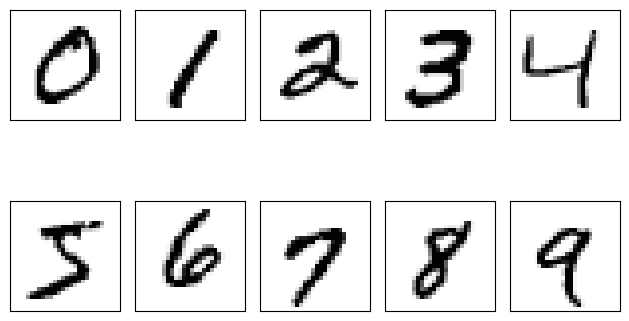

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = x_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Также выведем примеры одной цифры, чтобы посмотреть, как отличается почерк.

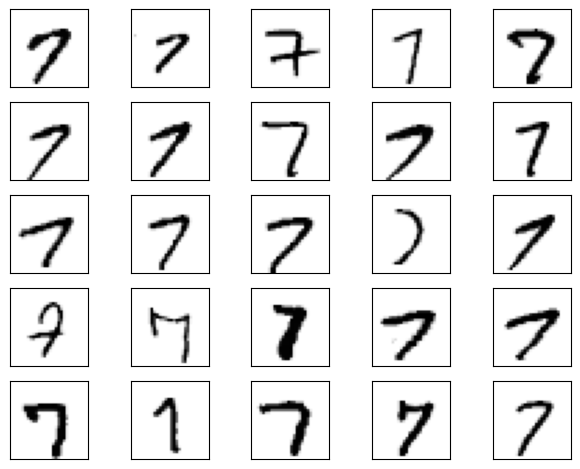

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = x_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Реализуем многослойный персептрон, имеющий только один скрытый слой, предназначенный для классификации изображений в наборе данных MNIST.

In [ ]:
x_train[:55000].shape

(55000, 784)

In [ ]:
class NeuralNetMLP(object):
    ''' Нейронная сеть прямого распространения / классификатор на основе
        многослойного персептрона.

        Параметры
        ---------
        n_hidden : int (по умолчанию: 30)
            Количество скрытых элементов.
        l2 : float (по умолчанию: 0)
            Значения лямбда для регуляризации L2
            Регуляризация отсутствует, если l2 = 0 (принято по умолчанию).
        epochs : int (по умолчанию: 100)
            Количество проходов по обучающему набору.
        eta : float (по умолчанию: 0.001)
            Скорость обучения.
        shuffle : bool (по умолчанию: True)
            Если True, тогда обучающие данные тасуются каждую каждую эпоху,
            чтобы предотвратить циклы.
        minibatch_size : int (по умолчанию: 1)
            Количество обучающих образцов на мини-пакет.
        seed : int (по умолчанию: None)
            Случайное начальное значение для инициализации весов и тасования.

        Атрибуты
        --------
        eval : dict
            Словарь, в котором собираются показатели издержек, правильности при
            обучении и правильности при испытании для каждой эпохи
            во время обучения.
        '''
    def __init__(self, n_hidden=30,
                 l2=0, epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        ''' Кодирует метки в представление с унитарным кодом

            Параметры
            ---------
            y : массив, форма = [n_examples]
                Целевые значения.

            Возвращает
            ----------
            onehot : массив, форма = (n_examples, n_labels)
            '''
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        ''' Вычисляет логистическую (сигмоидальную) функцию '''
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        ''' Вычисляет шаг прямого распространения '''
        # шаг 1: общий вход скрытого слоя
        # скалярное произведение [n_examples, n_features] и [n_features, n_hidden]
        # -> [n_examples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # шаг 2: активация скрытого слоя
        a_h = self._sigmoid(z_h)

        # шаг 3: общий вход выходного слоя
        # скалярное произведение [n_examples, n_hidden] и [n_hidden, n_classlabels]
        # -> [n_examples, n_classlabels]
        z_out = np.dot(a_h, self.w_out) + self.b_out

        # шаг 4: активация выходного слоя
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        ''' Вычисляет функцию издержек.

            Параметры
            ---------
            y_enc : массив, форма = (n_examples, n_labels)
                Метки классов в унитарном коде.
            output : массив, форма = [n_examples, n_output_units]
                Активация выходного слоя (прямое распространение)

            Возвращает
            ----------
            cost : float
                Регуляризированные издержки
            '''
        L2_term = (self.l2 * (np.sum(self.w_h ** 2.) + np.sum(self.w_out ** 2.)))
        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term

        return cost

    def predict(self, X):
        ''' Прогнозирует метки классов.

            Параметры
            ---------
            X : массив, форма = [n_examples, n_features]
                Входной слой с первоначальными признаками.

            Возвращает
            ----------
            y_pred : массив, форма = [n_examples]
                Спрогнозированные метки классов.
            '''
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)

        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        ''' Вычисляет веса из данных.

            Параметры
            ---------
            X_train : массив, форма = [n_examples, n_features]
                Входной слой с первоначальными признаками.
            y_train : массив, форма = [n_examples]
                Целевые метки классов.
            X_valid : массив, форма = [n_examples, n_features]
                Признаки образцов для проверки во время обучения.
            y_valid : массив, форма = [n_examples]
                Метки образцов для проверки во время обучения.

            Возвращает
            ----------
            self
            '''
        n_output = np.unique(y_train).shape[0] # Количество меток классов
        n_features = X_train.shape[1]

        #---------------------#
        # Инициализация весов #
        #---------------------#
        # Веса для входного слоя -> скрытого слоя
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # Веса для скрытого слоя -> выходного слоя
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs)) # Для формата
        self.eval_ = {'cost':[], 'train_acc':[], 'valid_acc':[]}
        y_train_enc = self._onehot(y_train, n_output)


        # Итерация по эпохам обучения
        for i in range(self.epochs):
          # итерация по мини-пакетам
          indices = np.arange(X_train.shape[0])
          if self.shuffle:
            self.random.shuffle(indices)
          for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1,
                                 self.minibatch_size):
            batch_idx = indices[start_idx:start_idx + self.minibatch_size]
            # Прямое распространение
            z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

            #--------------------------#
            # Обратное распространение #
            #--------------------------#
            # [n_examples, n_classlabels]
            delta_out = a_out - y_train_enc[batch_idx]

            # [n_examples, n_hidden]
            sigmoid_derivative_h = a_h * (1. - a_h)

            # скалярное произведение [n_examples, n_classlabels] и [n_classlabels, n_hidden]
            # -> [n_examples, n_hidden]
            delta_h = (np.dot(delta_out, self.w_out.T) * sigmoid_derivative_h)

            # скалярное произведение [n_features, n_examples] и [n_examples, n_hidden]
            # -> [n_features, n_hidden]
            grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
            grad_b_h = np.sum(delta_h, axis=0)


            # скалярное произведение [n_hidden, n_examples] и [n_examples, n_classlabels]
            # -> [n_hidden, n_classlabels]
            grad_w_out = np.dot(a_h.T, delta_out)
            grad_b_out = np.sum(delta_out, axis=0)

            # Регуляризация и обновление весов
            delta_w_h = (grad_w_h + self.l2 * self.w_h)
            delta_b_h = grad_b_h # смещение не регуляризуется
            self.w_h -= self.eta * delta_w_h
            self.b_h -= self.eta * delta_b_h

            delta_w_out = (grad_w_out + self.l2 * self.w_out)
            delta_b_out = grad_b_out # смещение не регуляризуется
            self.w_out -= self.eta * delta_w_out
            self.b_out -= self.eta * delta_b_out

          #--------#
          # Оценка #
          #--------#
          # Оценка после каждой эпохи во время обучения
          z_h, a_h, z_out, a_out = self._forward(X_train)
          cost = self._compute_cost(y_enc=y_train_enc, output=a_out)

          y_train_pred = self.predict(X_train)
          y_valid_pred = self.predict(X_valid)
          train_acc = ((np.sum(y_train == y_train_pred)).astype(float) /
                       X_train.shape[0])
          valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(float) /
                       X_valid.shape[0])
          sys.stderr.write('\r%0*d/%d | Издержки: %.2f | Правильность при'
          ' обучении/при проверке: %.2f%%/%.2f%%' % (epoch_strlen, i+1,
                                                     self.epochs, cost,
                                                     train_acc*100, valid_acc*100))
          sys.stderr.flush()
          self.eval_['cost'].append(cost)
          self.eval_['train_acc'].append(train_acc)
          self.eval_['valid_acc'].append(valid_acc)

        return self

После подготовки кода мы инициализируем новый многослойный персептрон
784-100-1 О - нейронную сеть, которая имеет 784 входных элемента
(n _ fea tures ), 100 скрытых элементов (n hidden) и 1 О выходных элементов
(n _ output):

In [ ]:
nn = NeuralNetMLP(n_hidden=100,
                  l2=0.01,
                  epochs=200,
                  eta=0.0005,
                  minibatch_size=100,
                  shuffle=True,
                  seed=1)

nn.fit(X_train=x_train[:55000],
       y_train=y_train[:55000],
       X_valid=x_train[55000:],
       y_valid=y_train[55000:])

<ipython-input-49-d77c30e3ac91>:218: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
<ipython-input-49-d77c30e3ac91>:220: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
200/200 | Издержки: 5065.78 | Правильность

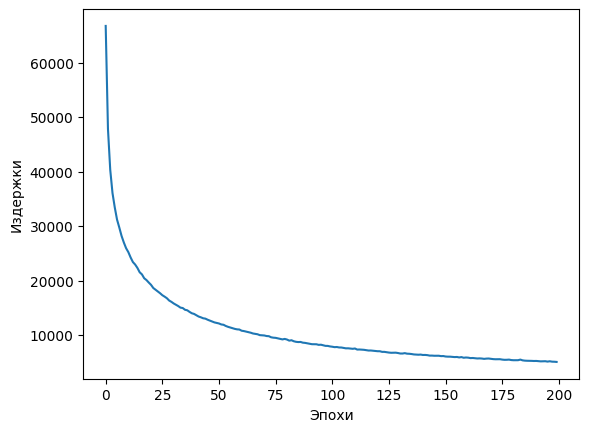

In [ ]:
plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Издержки')
plt.xlabel('Эпохи')
plt.show()

На графике видно, что издержки существенно уменьшаются в течение
первых 100 эпох и, кажется, медленно сходятся в последних l 00 эпохах.
Тем не менее, небольшой наклон между эпохами 175 и 200 указывает на то,
что издержки продолжат снижаться, если обучение продолжится в добавочных
эпохах.

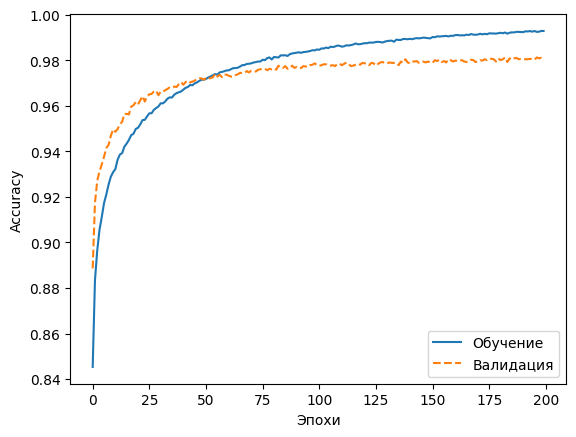

In [ ]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], label='Обучение')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], label='Валидация', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Эпохи')
plt.legend(loc='lower right')
plt.show()

На графике обнаруживается, что разрыв между правильностью при обучении
и правильностью при проверке растет с увеличением числа эпох, в
течение которых мы обучаем сеть. Примерно на 50-й эпохе значения правильности
при обучении и правильности при проверке становятся равными,
а затем сеть начинает переобучаться обучающими данными.

In [ ]:
y_test_pred = nn.predict(x_test)
acc = (np.sum(y_test == y_test_pred).astype(float) / x_test.shape[0])
print('Accuracy при испытании: %.2f%%' % (acc * 100))

Accuracy при испытании: 97.54%


Несмотря на незначительное переобучение обучающими данными, наша
относительно простая нейронная сеть с одним скрытым слоем достигает довольно
хорошей эффективности на испытательном наборе данных, которая
сравнима с правильностью на проверочном наборе (97.98%).

Наконец, давайте посмотрим, с какими изображениями сталкивался наш
многослойный персептрон:

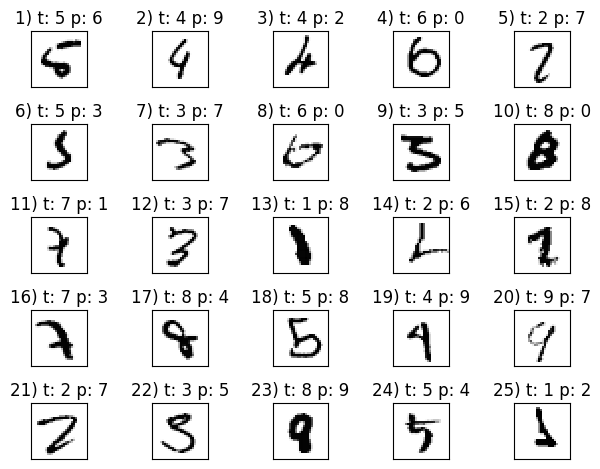

In [ ]:
miscl_img = x_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
  img = miscl_img[i].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys', interpolation='nearest')
  ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

* t - настоящая метка класса
* p - спрогнозированная метка класса

Как можно увидеть на графиках, есть надписи которые тяжело классифицировать даже человеку, но также имеются и те, которые для нас очевидны.